In [ ]:
import pandas as pd
df=pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
df.isnull().sum()

In [ ]:
df.duplicated().sum()

In [ ]:

column = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber']
for col in column:
    df.drop(columns=column, inplace=True)



In [ ]:
df.drop(columns='YearsWithCurrManager',inplace=True)

In [ ]:
df.shape

In [ ]:
df.info

In [ ]:
df.describe()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


In [ ]:
num_cols =df.select_dtypes(include='number').columns
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], palette="Set3")
    plt.title(f"Boxplot of {col}")
    plt.show()


In [ ]:

cat_cols = df.select_dtypes(include=['object','category']).columns

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, palette="pastel")
    plt.title(f"Countplot of {col}")
    plt.xticks(rotation=55)
    plt.show()


In [ ]:
plt.figure(figsize=(10,6))
corr=df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
drop_cols=['JobLevel', 'YearsInCurrentRole']
for i in drop_cols:
    df.drop(columns=i)

In [ ]:

categorical_cols=df.select_dtypes(include=['object']).columns

df_encoded=pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
from sklearn.preprocessing import StandardScaler
numeric_features = df.select_dtypes(include=['int','float']).columns

scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])


In [ ]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV

X=df.drop('Attrition', axis=1)
y=df['Attrition']  

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=42)


In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


Best params for RandomForest: {'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 113}
Best params for GradientBoosting: {'learning_rate': np.float64(0.19299193510875617), 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 132}


d:\python test\aug31\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:42:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params for XGBoost: {'learning_rate': np.float64(0.18000771555795989), 'max_depth': 4, 'n_estimators': 132, 'subsample': np.float64(0.7190675050858071)}

RandomForest Metrics:
Accuracy: 0.81, Precision: 0.43, Recall: 0.55, F1: 0.49
Confusion Matrix:
 [[213  34]
 [ 21  26]]

GradientBoosting Metrics:
Accuracy: 0.87, Precision: 0.71, Recall: 0.32, F1: 0.44
Confusion Matrix:
 [[241   6]
 [ 32  15]]

XGBoost Metrics:
Accuracy: 0.87, Precision: 0.75, Recall: 0.26, F1: 0.38
Confusion Matrix:
 [[243   4]
 [ 35  12]]

LogisticRegression Metrics:
Accuracy: 0.76, Precision: 0.36, Recall: 0.66, F1: 0.46
Confusion Matrix:
 [[191  56]
 [ 16  31]]


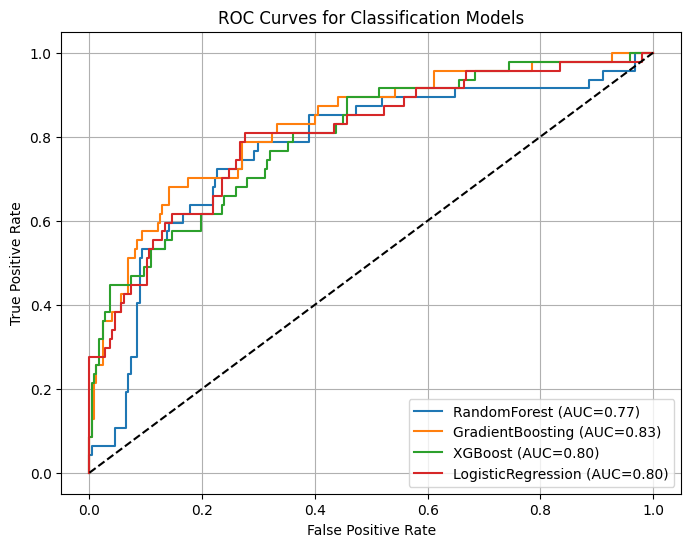

In [14]:
# ------------------- Libraries -------------------
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from scipy.stats import randint, uniform
import pickle as pkl

#
X = df.drop(['Attrition'], axis=1)  # Drop target
y = df['Attrition'].map({'Yes': 1, 'No': 0})  # Encode target

# ------------------- One-hot encoding -------------------
cat_cols = [col for col in X.columns if X[col].dtype=='object']
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# ------------------- Train/Test Split -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------- Scaling numeric features -------------------
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# ------------------- Hyperparameter distributions -------------------
param_dists = {
    "RandomForest": {
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 10),
        'max_features': ['sqrt', 'log2', None]
    },
    "GradientBoosting": {
        'n_estimators': randint(100, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 6),
        'max_features': ['sqrt', 'log2', None]
    },
    "XGBoost": {
        'n_estimators': randint(100, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 6),
        'subsample': uniform(0.7, 0.3)
    }
}

# ------------------- Models -------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# ------------------- RandomizedSearchCV for ensemble models -------------------
best_models = {}
for name in ["RandomForest", "GradientBoosting", "XGBoost"]:
    rand_search = RandomizedSearchCV(
        models[name],
        param_distributions=param_dists[name],
        n_iter=30,  
        cv=5,
        scoring='f1',
        n_jobs=-1,
        random_state=42
    )
    rand_search.fit(X_train, y_train)
    best_models[name] = rand_search.best_estimator_
    print(f"Best params for {name}: {rand_search.best_params_}")

# Fit Logistic Regression separately
best_models["LogisticRegression"] = models["LogisticRegression"]
best_models["LogisticRegression"].fit(X_train, y_train)

# ------------------- Evaluation & ROC Curve -------------------
plt.figure(figsize=(8,6))
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Metrics:")
    print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}")
    print("Confusion Matrix:\n", cm)

    # ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None

    if y_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Classification Models")
plt.legend()
plt.grid(True)
plt.show()

# ------------------- Save models & feature columns -------------------
with open("models.pkl", "wb") as f:
    pkl.dump(best_models, f)

pd.DataFrame(X_train.columns, columns=['feature']).to_csv("feature_cols.csv", index=False)
